In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm


In [2]:
FONT = 'AppleGothic'
plt.rc("font", family = FONT)
sns.set_theme(font=FONT, rc={"axes.unicode_minus":False}, style='white')

In [3]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

```
[배경]
'국민과 함께하는 데이터·AI를 활용한 물가 예측 경진대회 - 농산물 가격을 중심으로 -'를 개최합니다.

이번 대회를 통해 물가 예측 분야에서 데이터 AI 활용 역량을 강화하고, 국민들의 다양한 의견을 수렴하여 정책 의사결정에 반영하며 관련 산업의 활성화와 국민 편익 증진을 도모하는 것을 목표로 하고 있습니다. 특히 농산물 가격 예측을 중심으로 데이터를 활용한 실질적 해법을 모색함으로써, 데이터 기반의 정책 수립과 국민 경제에 기여할 수 있는 다양한 가능성을 탐구하고자 합니다.

[주제]
국민생활과 밀접한 10개 농산물 품목의 가격 예측
(배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)

[문제 상세 설명]
학습 데이터는 2018년 ~ 2021년의 순 단위(10일)의 데이터가 주어지며,

평가 데이터는 추론 시점 T가 비식별화된 2022년의 순 단위의 데이터가 주어집니다.

평가 데이터 추론은 추론 시점 T 기준으로 최대 3개월의 순 단위의 입력 데이터를 바탕으로 T+1순, T+2순, T+3순의 평균가격을 예측해야합니다.

예측해야할 Target은 (배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)의 10개의 품목 중 아래의 특정 품종, 등급에 대해서만 예측을 진행합니다.
```


# EDA 진행
## 1. 전체 데이터 분석

In [4]:
# 데이터 불러오기
DATA_DIR = '../data'

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train', 'train.csv'))
test_dfs = [
    pd.read_csv(os.path.join(DATA_DIR, 'test', f"TEST_{str(i).zfill(2)}.csv")) for i in range(25)
]

In [5]:
train_meta_산지공판장 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_산지공판장_2018-2021.csv'))
train_meta_전국도매 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_전국도매_2018-2021.csv'))

- meta 데이터 활용

In [6]:
set(train_df.columns) - set(train_meta_산지공판장.columns)

{'거래단위', '등급', '평균가격(원)', '평년 평균가격(원)'}

In [7]:
set(train_df.columns) - set(train_meta_전국도매.columns)

{'거래단위', '등급', '평균가격(원)', '평년 평균가격(원)'}

In [8]:
train_meta_산지공판장.head()

,시점,공판장코드,공판장명,품목코드,품목명,품종코드,품종명,등급코드,등급명,총반입량(kg),...,평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도
0,201801상순,1000000000,*전국농협공판장,501,감자,50101,수미,11,특,15470.0,...,1712.637363,1723.961039,1545.454545,2320.666667,7,1947.350427,1769.858320,1023.982379,0.0,2018
1,201801상순,1000000000,*전국농협공판장,501,감자,50101,수미,12,상,2900.0,...,1198.655172,1252.737207,893.055556,1417.857143,4,1301.239669,1348.253676,571.311475,0.0,2018
2,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,13,보통,1320.0,...,615.000000,600.000000,240.000000,911.875000,7,630.851064,449.166667,473.032787,0.0,2018
3,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,12,상,460.0,...,544.130435,365.000000,200.000000,1650.000000,5,1088.046875,1129.600000,734.024390,0.0,2018
4,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,11,특,30967.0,...,1876.454484,2010.440477,1598.327715,2438.720588,8,2126.402457,1779.262728,1750.544700,0.0,2018


In [9]:
train_meta_전국도매.head()

,시점,시장코드,시장명,품목코드,품목명,품종코드,품종명,총반입량(kg),총거래금액(원),평균가(원/kg),...,저가(20%) 평균가,중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도
0,201801상순,100000,*전국도매시장,501,감자,50124,깐감자,20.0,86520,4326.000000,...,4326.000000,4326.000000,4326.0,4326.000000,1,0.000000,4009.000000,0.000000,0.000000,2018
1,201801상순,100000,*전국도매시장,501,감자,50121,돼지감자,12380.0,11650810,941.099354,...,545.105717,1010.000000,200.0,3000.000000,117,11213.358450,9174.196723,8167.895632,0.000000,2018
2,201801상순,100000,*전국도매시장,501,감자,50110,자주감자,240.0,158400,660.000000,...,500.000000,550.000000,500.0,1000.000000,7,12553.279352,12612.216445,24990.324897,18483.961304,2018
3,201801상순,100000,*전국도매시장,501,감자,50111,가을감자,10.0,37500,3750.000000,...,3700.000000,3750.000000,3700.0,3800.000000,2,24929.463415,40365.081269,0.000000,0.000000,2018
4,201801상순,100000,*전국도매시장,501,감자,50199,기타감자,1367301.3,2403199462,1757.622451,...,955.289668,1360.453431,0.0,10581.081081,872,30806.779529,27661.150770,23741.953223,19340.121989,2018


In [10]:
f"산지공판장에만 있는 항목: {set(train_meta_산지공판장.columns) - set(train_meta_전국도매.columns)}"

"산지공판장에만 있는 항목: {'등급코드', '공판장명', '공판장코드', '등급명'}"

In [11]:
f"전국도매에만 있는 항목: {set(train_meta_전국도매.columns) - set(train_meta_산지공판장.columns)}"

"전국도매에만 있는 항목: {'고가(20%) 평균가', '저가(20%) 평균가', '시장코드', '중가(60%) 평균가 ', '시장명'}"

In [12]:
train_meta_전국도매 = train_meta_전국도매.drop(['저가(20%) 평균가', '고가(20%) 평균가', '중가(60%) 평균가 '], axis=1)
train_meta_전국도매['시장구분'] = '전국도매'

In [13]:
train_meta_산지공판장 = train_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드', '등급명'], axis=1)
train_meta_산지공판장['시장구분'] = '산지공판장'

In [14]:
train_meta = pd.concat([train_meta_전국도매, train_meta_산지공판장])

In [15]:
train_meta.sample(10)

,시점,시장코드,시장명,품목코드,품목명,품종코드,품종명,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
94875,202104상순,5058204356,경주농협 공판장,1101,무,110199,기타무,8320.0,2976900,357.800481,356.562500,324.375000,388.750000,8,389.176471,353.015873,0.000000,0.000000,2021,산지공판장
16783,201808하순,4058200313,김제원예농업협동조합공판장,1005,상추,100501,청상추,300.0,1921000,6403.333333,6187.500000,5000.000000,8605.263158,24,4206.185567,1340.909091,5859.154930,0.000000,2018,산지공판장
14822,201805상순,360301,순천,1209,마늘,120906,깐마늘,15580.0,97036000,6228.241335,6500.000000,5384.251969,6863.636364,6,6220.207254,5931.949686,6694.959514,5436.246950,2018,전국도매
66274,202004하순,4058200313,김제원예농업협동조합공판장,1101,무,110108,무말랭이,1.0,11600,11600.000000,11600.000000,11600.000000,11600.000000,1,7500.000000,0.000000,6300.000000,0.000000,2020,산지공판장
96603,202002하순,350101,전주,1005,상추,100501,청상추,22796.0,31405200,1377.662748,1134.375000,500.000000,2200.000000,67,1506.921549,3533.133641,1577.558563,4930.961655,2020,전국도매
66824,202005상순,4028210938,전주농협공판장,602,배,60201,신고,75.0,69000,920.000000,900.000000,866.666667,933.333333,3,657.142857,1084.276730,0.000000,0.000000,2020,산지공판장
126462,202011상순,220001,대구북부,1001,배추,100199,기타배추,278463.0,95507800,342.982012,420.000000,100.000000,5000.000000,131,400.771136,1117.065965,542.908285,1664.949406,2020,전국도매
14931,201805상순,380201,울산,601,사과,60139,미시마,11770.0,28647800,2433.967715,2476.849643,1572.093023,3087.666667,10,2046.487252,1749.842845,21721.734719,28903.721656,2018,전국도매
5522,201802중순,340101,천안,602,배,60201,신고,29477.5,42665200,1447.381901,1533.031068,566.666667,1875.000000,10,2079.358359,1740.323834,26298.985507,0.000000,2018,전국도매
100159,202003하순,380101,창원팔용,1005,상추,100502,적상추,4901.0,6481400,1322.464803,1090.504535,750.000000,2800.000000,42,1668.943299,1148.472298,2172.227473,3037.773788,2020,전국도매


In [16]:
train_df.columns

Index(['시점', '품목명', '품종명', '거래단위', '등급', '평년 평균가격(원)', '평균가격(원)'], dtype='object')

In [17]:
train_merge = train_df.merge(train_meta, on=['시점', '품목명', '품종명'], how='left')

In [18]:
train_merge['시장코드'].isna().sum() / train_merge.shape[0] * 100

np.float64(4.090505664580276)

In [19]:
train_merge.sample(10)

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원),시장코드,시장명,품목코드,...,중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
131917,201811하순,무,다발무,5톤트럭,상,3.753226e+06,3.532586e+06,1.000000e+09,*전국농협공판장,1101.0,...,169.000000,113.595779,263.559322,9.0,203.764182,255.617819,149.541395,0.000000,2018.0,산지공판장
37033,201805중순,감자,감자,20키로상자,상,0.000000e+00,0.000000e+00,1.100080e+05,서울강서,501.0,...,1190.000000,1190.000000,1190.000000,1.0,3100.000000,4315.799257,0.000000,0.000000,2018.0,전국도매
331311,201911상순,대파,대파(일반),1키로단,중,1.206782e+03,1.118750e+03,6.118205e+09,거창사과원예농협,1202.0,...,1034.090909,800.000000,1139.344262,21.0,1093.649194,1106.505771,1249.455677,0.000000,2019.0,산지공판장
305781,201909중순,대파,대파(일반),1키로단,특,2.182922e+03,1.910143e+03,3.108204e+09,충서원협농산물공판장,1202.0,...,1500.000000,1373.584906,1569.230769,11.0,1036.265709,1284.732824,2064.827872,0.000000,2019.0,산지공판장
303042,201805하순,대파,대파(일반),1키로단,특,1.719496e+03,1.583400e+03,3.088205e+09,논산계룡농협농산물공판장,1202.0,...,625.000000,293.918919,1100.000000,8.0,621.525886,347.567568,1073.880597,0.000000,2018.0,산지공판장
40932,201908상순,감자,홍감자,10키로상자,중,0.000000e+00,0.000000e+00,2.200010e+05,대구북부,501.0,...,725.000000,116.666667,1550.000000,6.0,526.136364,791.925466,1291.000000,0.000000,2019.0,전국도매
55023,201805중순,배,신고,10 개,중품,2.097367e+04,1.885800e+04,4.028211e+09,전주농협공판장,602.0,...,900.000000,800.000000,1066.666667,3.0,666.666667,847.058824,1325.000000,0.000000,2018.0,산지공판장
307608,202008중순,대파,대파(일반),1키로단,특,1.990870e+03,3.276444e+03,3.801010e+05,창원팔용,1202.0,...,1892.857143,380.000000,2813.151042,61.0,1581.358440,1389.723611,1501.219008,1658.349882,2020.0,전국도매
113826,201909상순,무,다발무,8톤트럭,하,0.000000e+00,0.000000e+00,2.100010e+05,부산엄궁,1101.0,...,1062.500000,250.000000,1392.857143,8.0,879.132231,0.000000,5000.000000,3873.414736,2019.0,전국도매
116789,201811상순,무,다발무,8톤트럭,중,0.000000e+00,0.000000e+00,4.028211e+09,전주농협공판장,1101.0,...,190.921053,57.440476,300.000000,23.0,207.058824,353.385417,230.158730,0.000000,2018.0,산지공판장


In [20]:
# train_df 확인
train_df.shape

(29376, 7)

In [21]:
train_df.head()

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,201801상순,건고추,화건,30 kg,상품,381666.666667,590000.0
1,201801중순,건고추,화건,30 kg,상품,380809.666667,590000.0
2,201801하순,건고추,화건,30 kg,상품,380000.000000,590000.0
3,201802상순,건고추,화건,30 kg,상품,380000.000000,590000.0
4,201802중순,건고추,화건,30 kg,상품,376666.666667,590000.0


In [22]:
train_df.dtypes

시점             object
품목명            object
품종명            object
거래단위           object
등급             object
평년 평균가격(원)    float64
평균가격(원)       float64
dtype: object

In [23]:
train_df.describe(include='all')

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
count,29376,29376,29376,29376,29376,2.937600e+04,2.937600e+04
unique,144,10,41,25,6,NaN,NaN
top,201801상순,양파,양파,20키로상자,상,NaN,NaN
freq,204,9792,2880,4752,7056,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.772730e+04,5.224625e+04
std,NaN,NaN,NaN,NaN,NaN,1.521004e+05,4.545482e+05
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.055214e+03
75%,NaN,NaN,NaN,NaN,NaN,5.203333e+02,1.289481e+04


In [24]:
set(train_df['시점'])

{'201801상순',
 '201801중순',
 '201801하순',
 '201802상순',
 '201802중순',
 '201802하순',
 '201803상순',
 '201803중순',
 '201803하순',
 '201804상순',
 '201804중순',
 '201804하순',
 '201805상순',
 '201805중순',
 '201805하순',
 '201806상순',
 '201806중순',
 '201806하순',
 '201807상순',
 '201807중순',
 '201807하순',
 '201808상순',
 '201808중순',
 '201808하순',
 '201809상순',
 '201809중순',
 '201809하순',
 '201810상순',
 '201810중순',
 '201810하순',
 '201811상순',
 '201811중순',
 '201811하순',
 '201812상순',
 '201812중순',
 '201812하순',
 '201901상순',
 '201901중순',
 '201901하순',
 '201902상순',
 '201902중순',
 '201902하순',
 '201903상순',
 '201903중순',
 '201903하순',
 '201904상순',
 '201904중순',
 '201904하순',
 '201905상순',
 '201905중순',
 '201905하순',
 '201906상순',
 '201906중순',
 '201906하순',
 '201907상순',
 '201907중순',
 '201907하순',
 '201908상순',
 '201908중순',
 '201908하순',
 '201909상순',
 '201909중순',
 '201909하순',
 '201910상순',
 '201910중순',
 '201910하순',
 '201911상순',
 '201911중순',
 '201911하순',
 '201912상순',
 '201912중순',
 '201912하순',
 '202001상순',
 '202001중순',
 '202001하순',
 '202002상순',
 '202002중순',

In [25]:
품종_거래단위_등급별_시점 = train_df[['시점','품종명', '품목명', '거래단위', '등급']].groupby(['품목명', '품종명', '거래단위', '등급']).agg(lambda x: len(set(x)))

In [26]:
품종_거래단위_등급별_시점[품종_거래단위_등급별_시점['시점'] != 144]

시점
품목명 품종명 거래단위 등급     
사과  홍로  10 개 상품   19
    후지  10 개 상품  125

In [27]:
홍로_후지_상품 = train_df[(train_df['품종명'].isin(['홍로','후지'])) & (train_df['등급'] == '상품')].sort_values('시점')

In [28]:
홍로_후지_상품['시점'].nunique()

144

- 품종,거래단위,등급 별 데이터의 수를 살펴보면, 모두 144개로 3x4x12 4년치의 순별 데이터가 모두 존재함을 알 수 있다.
- 다만, 사과의 홍로, 후지의 경우 '상품'의 데이터가 비어있는데, 두개를 합치면 144개 시점 모두가 채워진다. 즉 홍로와, 후지는 동일한 품종으로 처리해야 함.

In [29]:
# 품목별 품종, 거래단위, 등급 의 개수
train_df[['품목명', '품종명', '거래단위', '등급']].groupby('품목명').agg({'품종명': set, '거래단위':set, '등급': set})

,품종명,거래단위,등급
품목명,,,
감자,"{감자 수미, 감자, 감자 수미(햇), 감자 조풍, 감자 두백, 감자 수미(저장),...","{23키로상자, 10키로상자, 20키로상자}","{특, 상, 하, 중}"
건고추,"{화건, 햇산양건, 햇산화건, 양건}",{30 kg},"{상품, 중품}"
깐마늘(국산),{깐마늘(국산)},{20 kg},"{상품, 중품}"
대파,"{실파, 쪽파, 대파 수입, 대파(일반), 깐쪽파}","{20키로, 1키로단, 10키로묶음, 10키로상자}","{중, 상, 하, 특}"
무,"{열무, 다발무, 무}","{4키로상자, 18키로상자(비닐포), 8톤트럭, 20키로상자, 5톤트럭, 10키로,...","{중, 상, 하, 특}"
배,"{원황, 신고}",{10 개},"{상품, 중품}"
배추,"{쌈배추, 얼갈이배추, 봄동배추, 절임배추, 배추, 알배기배추}","{10키로망대, 1키로상자, 4키로상자, 20키로상자, 8키로상자, 15키로상자}","{하, 상, 중, 특}"
사과,"{쓰가루, 홍로, 후지}",{10 개},"{상품, 중품}"
상추,"{청, 적}",{100 g},"{상품, 중품}"


In [30]:
train_df[['품목명', '등급', '거래단위']].groupby(['품목명', '등급']).agg({'거래단위': set})

거래단위
품목명     등급                                                   
감자      상                            {23키로상자, 10키로상자, 20키로상자}
        중                                    {10키로상자, 20키로상자}
        특                                    {10키로상자, 20키로상자}
        하                                    {10키로상자, 20키로상자}
건고추     상품                                            {30 kg}
        중품                                            {30 kg}
깐마늘(국산) 상품                                            {20 kg}
        중품                                            {20 kg}
대파      상                        {20키로, 1키로단, 10키로묶음, 10키로상자}
        중                        {20키로, 1키로단, 10키로묶음, 10키로상자}
        특                        {20키로, 1키로단, 10키로묶음, 10키로상자}
        하                        {20키로, 1키로단, 10키로묶음, 10키로상자}
무       상   {4키로상자, 18키로상자(비닐포), 8톤트럭, 20키로상자, 5톤트럭, 5000키...
        중   {4키로상자, 18키로상자(비닐포), 8톤트럭, 20키로상자, 5톤트럭, 10키로,...
        특   {18키로상자(비닐포), 20키로상자, 5톤트럭, 10키로, 5000키로, 1000키로}
        하   {4키로상자, 18키로상자(비닐포), 8톤트럭, 20키로상자, 5톤트럭, 10키로,...
배       상품                                             {10 개}
        중품                                             {10 개}
배추      상       {10키로망대, 1키로상자, 4키로상자, 20키로상자, 8키로상자, 15키로상자}
        중               {10키로망대, 1키로상자, 4키로상자, 8키로상자, 15키로상자}
        특                              {10키로망대, 8키로상자, 1키로상자}
        하               {10키로망대, 1키로상자, 4키로상자, 8키로상자, 15키로상자}
사과      상품                                             {10 개}
        중품                                             {10 개}
상추      상품                                            {100 g}
        중품                                            {100 g}
양파      상                       {20키로, 15키로, 12키로, 10키로, 1키로}
        중                       {20키로, 12키로, 15키로, 10키로, 1키로}
        특                       {20키로, 12키로, 15키로, 10키로, 1키로}
        하                       {20키로, 15키로, 12키로, 10키로, 1키로}

- 품목별로 다양한 품종이 존재하고, 각 품종별로 등급이 존재. 품종/등급을 거래 단위로 묶어 판매함

In [31]:
train_df[['품목명','품종명', '등급', '거래단위']].groupby(['품목명','품종명', '등급']).agg({'거래단위': set})

거래단위
품목명 품종명   등급                    
감자  감자    상             {20키로상자}
          중             {20키로상자}
          특             {20키로상자}
          하             {20키로상자}
    감자 대지 상             {20키로상자}
...                          ...
양파  저장양파  하   {12키로, 15키로, 20키로}
    조생양파  상         {15키로, 12키로}
          중         {15키로, 12키로}
          특         {15키로, 12키로}
          하         {15키로, 12키로}

[128 rows x 1 columns]

- 다발무의 '특' 을 제외하고, 같은 품종인 경우 같은 거래단위로 판매됨
- 등급은 모든 품종에 대해 [특, 상, 중, 하] 범주에서 구분 가능

---

In [32]:
set(train_df.columns) - set(test_dfs[0].columns)

set()

- train 데이터와 test 데이터간 원본 feature 차이는 없음

In [33]:
test_dfs[0].shape

(1836, 7)

In [34]:
# For train_df
train_df.loc[train_df['품종명'] == '후지', '품종명'] = '홍로'

# For each test_df in test_dfs
for test_df in test_dfs:
    test_df.loc[test_df['품종명'] == '후지', '품종명'] = '홍로'

In [35]:
테스트_품목_품종_거래단위_등급 = [test_df[['품목명', '품종명', '거래단위', '등급', '시점']].groupby(['품목명','품종명','거래단위','등급']).agg(lambda x: len(set(x))) for test_df in test_dfs]

In [36]:
for data in 테스트_품목_품종_거래단위_등급:
    if data[data['시점'] != 9].shape[0] > 0:
        print("전처리 에러")

In [37]:
test_dfs[0].head()

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,T-8순,건고추,화건,30 kg,상품,537302.666667,552000.0
1,T-7순,건고추,화건,30 kg,상품,534742.000000,555743.0
2,T-6순,건고추,화건,30 kg,상품,537408.666667,559794.0
3,T-5순,건고추,화건,30 kg,상품,592768.000000,578819.0
4,T-4순,건고추,화건,30 kg,상품,0.000000,579167.0


In [38]:
test_dfs[1].head()

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,T-8순,건고추,화건,30 kg,상품,592768.000000,578819.0
1,T-7순,건고추,화건,30 kg,상품,0.000000,579167.0
2,T-6순,건고추,화건,30 kg,상품,637704.333333,539583.0
3,T-5순,건고추,화건,30 kg,상품,635516.666667,597600.0
4,T-4순,건고추,화건,30 kg,상품,637272.333333,671225.0


In [39]:
test_dfs[0].describe(include='all')

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
count,1836,1836,1836,1836,1836,1836.000000,1836.000000
unique,9,10,40,25,6,NaN,NaN
top,T-8순,양파,양파,20키로상자,상,NaN,NaN
freq,204,612,180,297,441,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,17475.445098,36026.517669
std,NaN,NaN,NaN,NaN,NaN,82657.516605,111792.746825
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000,9688.555556
75%,NaN,NaN,NaN,NaN,NaN,3804.011508,22551.410714


### 1-1. 분석 목적 + 목적 별 변수 지정

- 각 데이터 포인트는 10일 단위로 구성됨
- train 데이터는 2018 ~ 2021년의 시계열 데이터가 존재
- test 데이터는 임의의 추론 시점 T 기준 과거 T-8 까지 3개월의 데이터를 입력으로 T+1, T+2, T+3 단위의 평균가격을 예측해야 함
- Many To Many 회귀 테스트
- 사용 가능한 feature set:
  - 품목명
  - 품종명
  - 거래단위
  - 등급
  - 평년가격
- Target: 평균가격

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29376 entries, 0 to 29375
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시점          29376 non-null  object 
 1   품목명         29376 non-null  object 
 2   품종명         29376 non-null  object 
 3   거래단위        29376 non-null  object 
 4   등급          29376 non-null  object 
 5   평년 평균가격(원)  29376 non-null  float64
 6   평균가격(원)     29376 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.6+ MB


In [41]:
테스트_병합 = pd.concat(test_dfs)

In [42]:
테스트_병합.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45900 entries, 0 to 1835
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시점          45900 non-null  object 
 1   품목명         45900 non-null  object 
 2   품종명         45900 non-null  object 
 3   거래단위        45900 non-null  object 
 4   등급          45900 non-null  object 
 5   평년 평균가격(원)  45900 non-null  float64
 6   평균가격(원)     45900 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.8+ MB


---
### 1-2. 데이터 타입 확인

In [43]:
train_df.dtypes

시점             object
품목명            object
품종명            object
거래단위           object
등급             object
평년 평균가격(원)    float64
평균가격(원)       float64
dtype: object

In [44]:
테스트_병합.dtypes

시점             object
품목명            object
품종명            object
거래단위           object
등급             object
평년 평균가격(원)    float64
평균가격(원)       float64
dtype: object

---
### 1-3. 오류, 누락 확인

In [45]:
object_features = ['시점', '품목명', '품종명', '거래단위', '등급']

In [46]:
train_df[object_features].isna().any(axis=1).sum()

np.int64(0)

In [47]:
테스트_병합[object_features].isna().any(axis=1).sum()

np.int64(0)

- object 타입의 feature에는 결측치 없음

#### Numeric 값 결측치

In [48]:
train_df.columns

Index(['시점', '품목명', '품종명', '거래단위', '등급', '평년 평균가격(원)', '평균가격(원)'], dtype='object')

In [49]:
numeric_features = ['평년 평균가격(원)', '평균가격(원)']

In [50]:
train_df[numeric_features].describe()

,평년 평균가격(원),평균가격(원)
count,2.937600e+04,2.937600e+04
mean,1.772730e+04,5.224625e+04
std,1.521004e+05,4.545482e+05
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.055214e+03
75%,5.203333e+02,1.289481e+04
max,5.213802e+06,1.335000e+07


In [51]:
print("train data")
for feature in numeric_features:
    print(f"{feature} 결측치 비율 : {train_df[train_df[feature] == .0].shape[0] / train_df.shape[0] * 100} %")

train data
평년 평균가격(원) 결측치 비율 : 74.41448801742919 %
평균가격(원) 결측치 비율 : 43.276824618736384 %


- train 데이터에서 target 값이 0인 경우가 43%로 굉장히 높다

In [52]:
print("test data")
for feature in numeric_features:
    print(f"{feature} 결측치 비율 : {테스트_병합[테스트_병합[feature] == .0].shape[0] / 테스트_병합.shape[0] * 100} %")

test data
평년 평균가격(원) 결측치 비율 : 67.0718954248366 %
평균가격(원) 결측치 비율 : 34.08496732026144 %


- target이 결측인 경우 사용이 불가하므로, 제거한 상태로 변환

In [53]:
train_with_target_df = train_df[train_df['평균가격(원)'] != .0]
test_with_target_df = 테스트_병합[테스트_병합['평균가격(원)'] != .0]

In [54]:
train_with_target_df.shape

(16663, 7)

In [55]:
test_with_target_df.shape

(30255, 7)

---
### 1-4. 예측 범위 분포 확인

In [56]:
train_with_target_df.describe()

,평년 평균가격(원),평균가격(원)
count,1.666300e+04,1.666300e+04
mean,3.125231e+04,9.210742e+04
std,2.009063e+05,6.004895e+05
min,0.000000e+00,1.341250e+02
25%,0.000000e+00,4.145262e+03
50%,0.000000e+00,1.099425e+04
75%,6.701246e+03,2.338981e+04
max,5.213802e+06,1.335000e+07


In [57]:
test_with_target_df.describe()

,평년 평균가격(원),평균가격(원)
count,30255.000000,3.025500e+04
mean,24451.147249,6.335911e+04
std,96989.932307,3.331929e+05
min,0.000000,1.410000e+02
25%,0.000000,5.766000e+03
50%,0.000000,1.455089e+04
75%,10965.088889,2.877900e+04
max,769966.666667,8.422222e+06


- 학습데이터의 target은 평균 92,000원, 테스트 데이터의 target은 평균 63,000원

---
## 2. 개별 속성값 관찰
### 2-1. 개별 데이터 추세 및 특이사항 파악

- 품목명과 target 연관

In [58]:
품목명별_평균가격 = train_with_target_df[['품목명', '평균가격(원)']].groupby('품목명')

In [59]:
품목명별_평균가격.describe()

평균가격(원)                                                          \
          count           mean           std         min            25%   
품목명                                                                       
감자       1938.0   27927.331888  1.734609e+04    3836.000   15088.687500   
건고추       598.0  643115.490803  1.681523e+05  345000.000  521668.750000   
깐마늘(국산)   288.0  116155.859375  2.811972e+04   64500.000   86151.000000   
대파       2073.0   38833.626596  3.878490e+04     318.375    2997.375000   
무        1697.0  518825.557775  1.786717e+06     385.625    2519.333333   
배         314.0   30712.719745  8.466227e+03   17524.000   23390.750000   
배추       3254.0    9657.950235  7.267548e+03    1007.400    4463.958333   
사과        321.0   20795.151090  5.528956e+03   11185.000   16151.000000   
상추        576.0     867.921875  3.840668e+02     402.000     591.000000   
양파       5604.0    9534.591066  7.628500e+03     134.125    1265.843750   

                                                     
                   50%            75%           max  
품목명                                                  
감자        24154.000000   35591.111111  1.289320e+05  
건고추      610312.500000  712800.000000  1.070075e+06  
깐마늘(국산)  122518.750000  136621.375000  1.691000e+05  
대파        31998.000000   56241.888889  2.660423e+05  
무          6148.625000   10973.625000  1.335000e+07  
배         30145.500000   36290.000000  5.346300e+04  
배추         7503.243056   12566.083333  6.510838e+04  
사과        20044.000000   24801.000000  3.533900e+04  
상추          759.000000    1009.250000  2.403000e+03  
양파         9162.250000   14136.722222  4.032186e+04

- 품종명과 target

In [60]:
품종명별_평균가격 = train_with_target_df[['품종명', '평균가격(원)']].groupby('품종명')

In [61]:
품종명별_평균가격.describe()

평균가격(원)                                                            \
            count          mean           std            min            25%   
품종명                                                                           
감자          452.0  2.688005e+04  1.669109e+04    4372.750000   13524.284722   
감자 대지       356.0  2.972058e+04  1.751673e+04    3987.125000   16953.000000   
감자 두백       116.0  2.277187e+04  9.047522e+03    4158.222222   15296.000000   
감자 수미       576.0  3.025530e+04  2.025995e+04    4366.625000   15215.750000   
감자 수미(저장)   140.0  1.820723e+04  8.406207e+03    3836.000000   11024.166667   
감자 수미(햇)    248.0  3.008912e+04  1.661221e+04    6808.500000   18851.008929   
감자 수입        46.0  2.779885e+04  4.922452e+03   18479.444444   27250.000000   
깐마늘(국산)     288.0  1.161559e+05  2.811972e+04   64500.000000   86151.000000   
깐쪽파         576.0  5.773650e+04  3.383577e+04    9839.400000   33892.156250   
다발무         205.0  4.243964e+06  3.267943e+06    1060.000000    6908.444444   
대파 수입        21.0  7.238342e+03  5.243411e+03    2598.125000    3630.000000   
대파(일반)      576.0  1.664837e+03  9.844529e+02     318.375000    1000.895833   
무           628.0  1.142818e+04  6.104130e+03    1664.222222    7179.972222   
배추          576.0  6.499639e+03  4.407129e+03    1081.000000    3266.895833   
봄동배추        270.0  1.590735e+04  7.577149e+03    4800.000000    9953.071429   
신고          286.0  3.110527e+04  8.621324e+03   17524.000000   23658.000000   
실파          324.0  7.945147e+04  4.552851e+04   18138.000000   48263.975000   
쌈배추        1104.0  8.930015e+03  5.809664e+03    1073.625000    4512.458333   
쓰가루          25.0  1.680404e+04  3.237724e+03   11185.000000   14965.000000   
알배기배추       576.0  1.412122e+04  8.727863e+03    2600.666667    7944.750000   
양건          286.0  7.086929e+05  1.715443e+05  460000.000000  600000.000000   
양파         2520.0  9.416140e+03  6.952322e+03     148.250000    3597.309524   
양파 수입       376.0  8.822730e+02  2.649181e+02     203.000000     737.677083   
양파(햇)       604.0  1.475106e+04  6.285946e+03    4283.125000   10120.583333   
얼갈이배추       681.0  5.926899e+03  3.555631e+03    1007.400000    3267.750000   
열무          864.0  3.770203e+03  2.905315e+03     385.625000    1530.444444   
원황           28.0  2.670314e+04  5.296482e+03   17549.000000   21700.000000   
자주양파       1616.0  7.536259e+03  7.110540e+03     134.125000     895.666667   
저장양파        488.0  1.697378e+04  6.522673e+03    5086.222222   12030.458333   
적           288.0  8.711354e+02  3.742839e+02     428.000000     605.000000   
절임배추         47.0  2.892378e+04  2.557367e+03   23656.714286   27908.700000   
쪽파          576.0  3.540391e+04  1.974032e+04    6156.500000   21586.944444   
청           288.0  8.647083e+02  3.942326e+02     402.000000     561.750000   
햇산양건         11.0  7.923582e+05  1.584635e+05  522500.000000  723399.000000   
햇산화건         14.0  6.885768e+05  1.482448e+05  442031.000000  598839.500000   
홍감자           4.0  8.602500e+03  2.017693e+03    6338.000000    7375.250000   
홍로          296.0  2.113224e+04  5.553667e+03   11757.000000   16556.750000   
화건          287.0  5.698289e+05  1.310443e+05  345000.000000  494800.000000   

                                                     
                    50%           75%           max  
품종명                                                  
감자         2.333151e+04  3.498396e+04  8.092633e+04  
감자 대지      2.511444e+04  4.291083e+04  8.825000e+04  
감자 두백      2.322661e+04  3.000326e+04  4.318880e+04  
감자 수미      2.523487e+04  4.076446e+04  1.289320e+05  
감자 수미(저장)  1.789117e+04  2.512923e+04  3.619000e+04  
감자 수미(햇)   2.718623e+04  3.607367e+04  8.428400e+04  
감자 수입      2.725000e+04  2.838400e+04  3.775000e+04  
깐마늘(국산)    1.225188e+05  1.366214e+05  1.691000e+05  
깐쪽파        5.027681e+04  7.195254e+04  2.376029e+05  
다발무        4.200000e+06  5.750000e+06  1.335000e+07  
대파 수입      3.630000e+03  1.286667e+04  1.721617e+04  
대파(일반)     1.4

- 거래단위 vs target

In [62]:
거래단위별_평균가격 = train_with_target_df[['거래단위', '평균가격(원)']].groupby('거래단위')

In [63]:
거래단위별_평균가격.describe()

평균가격(원)                                                          \
              count          mean           std           min           25%   
거래단위                                                                          
1.5키로단        432.0  1.721829e+03  8.883834e+02  3.856250e+02  1.123250e+03   
10 개          635.0  2.569927e+04  8.685674e+03  1.118500e+04  1.913100e+04   
100 g         576.0  8.679219e+02  3.840668e+02  4.020000e+02  5.910000e+02   
10키로          280.0  9.017303e+03  4.987995e+03  1.060000e+03  4.715292e+03   
10키로망대        576.0  6.499639e+03  4.407129e+03  1.081000e+03  3.266896e+03   
10키로상자       1177.0  4.573942e+04  3.007928e+04  2.598125e+03  2.554925e+04   
12키로         1440.0  9.976131e+03  5.129905e+03  9.000000e+02  6.239576e+03   
15키로          980.0  1.354125e+04  5.491892e+03  3.214333e+03  9.849861e+03   
15키로상자        270.0  1.590735e+04  7.577149e+03  4.800000e+03  9.953071e+03   
18키로상자(비닐포)    52.0  1.574672e+04  7.144466e+03  2.448500e+03  9.497268e+03   
1키로          1528.0  7.938953e+02  3.388163e+02  1.341250e+02  5.462812e+02   
1키로단          576.0  1.664837e+03  9.844529e+02  3.183750e+02  1.000896e+03   
1키로상자         528.0  6.263250e+03  4.561623e+03  1.073625e+03  3.447394e+03   
20 kg         288.0  1.161559e+05  2.811972e+04  6.450000e+04  8.615100e+04   
20키로         1752.0  2.738411e+04  3.220370e+04  2.693375e+03  1.111450e+04   
20키로상자       2511.0  2.410494e+04  1.702915e+04  1.664222e+03  1.118500e+04   
23키로상자         46.0  2.779885e+04  4.922452e+03  1.847944e+04  2.725000e+04   
30 kg         598.0  6.431155e+05  1.681523e+05  3.450000e+05  5.216688e+05   
4키로상자         864.0  5.356690e+03  2.793087e+03  1.007400e+03  3.323762e+03   
5톤트럭          126.0  5.222345e+06  2.139677e+06  1.523892e+06  4.002656e+06   
8키로상자        1401.0  1.185384e+04  7.286464e+03  1.832333e+03  6.868111e+03   
8톤트럭           27.0  7.845200e+06  2.776799e+06  4.200000e+06  5.560000e+06   

                                                       
                      50%           75%           max  
거래단위                                                   
1.5키로단       1.532389e+03  2.097328e+03  6.929444e+03  
10 개         2.452200e+04  3.209700e+04  5.346300e+04  
100 g        7.590000e+02  1.009250e+03  2.403000e+03  
10키로         8.854028e+03  1.149500e+04  2.640000e+04  
10키로망대       5.512167e+03  8.557400e+03  3.090325e+04  
10키로상자       3.879067e+04  5.749038e+04  2.376029e+05  
12키로         9.224076e+03  1.236073e+04  2.934200e+04  
15키로         1.266462e+04  1.590449e+04  3.278500e+04  
15키로상자       1.563065e+04  2.099700e+04  3.839470e+04  
18키로상자(비닐포)  1.587167e+04  2.165871e+04  3.000700e+04  
1키로          7.880903e+02  9.795000e+02  2.408111e+03  
1키로단         1.407714e+03  1.950458e+03  5.753000e+03  
1키로상자        4.666667e+03  7.298625e+03  3.646200e+04  
20 kg        1.225188e+05  1.366214e+05  1.691000e+05  
20키로         1.688633e+04  2.590475e+04  2.660423e+05  
20키로상자       1.987967e+04  3.130796e+04  1.289320e+05  
23키로상자       2.725000e+04  2.838400e+04  3.775000e+04  
30 kg        6.103125e+05  7.128000e+05  1.070075e+06  
4키로상자        4.704833e+03  6.880708e+03  2.129411e+04  
5톤트럭         4.500000e+06  6.221065e+06  1.164635e+07  
8키로상자        1.024625e+04  1.488611e+04  6.510838e+04  
8톤트럭         7.250000e+06  9.700000e+06  1.335000e+07

- 등급 vs target

In [64]:
등급별_평균가격 = train_with_target_df[['등급', '평균가격(원)']].groupby('등급')

In [65]:
등급별_평균가격.describe()

평균가격(원)                                                                    \
     count           mean            std      min          25%           50%   
등급                                                                             
상   3882.0   88379.555152  722749.569235  242.000  5468.888889  11751.158730   
상품  1048.0  218626.934478  303834.116330  621.000  1632.750000  34368.500000   
중   3768.0   70195.613624  570517.319362  199.200  4121.166667   9391.571429   
중품  1049.0  196123.817127  279204.018518  402.000  1065.000000  24658.000000   
특   3148.0   91715.940430  758526.809934  253.000  7817.041667  14791.750000   
하   3768.0   54040.016285  440279.097627  134.125  2763.593750   6478.312500   

                                 
              75%           max  
등급                               
상    23451.250000  1.335000e+07  
상품  510000.000000  1.070075e+06  
중    17690.356250  1.098111e+07  
중품  460000.000000  9.847500e+05  
특    29434.441667  1.164635e+07  
하    12140.093750  8.111111e+06

- 평년가격 vs target

In [66]:
평년가격존재 = train_with_target_df[train_with_target_df['평년 평균가격(원)'] != .0]
평년가격존재['가격차이'] = 평년가격존재['평균가격(원)'] - 평년가격존재['평년 평균가격(원)']

/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75394/555109564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  평년가격존재['가격차이'] = 평년가격존재['평균가격(원)'] - 평년가격존재['평년 평균가격(원)']


In [67]:
평년가격존재.describe()

,평년 평균가격(원),평균가격(원),가격차이
count,7.516000e+03,7.516000e+03,7.516000e+03
mean,6.928648e+04,9.704721e+04,2.776073e+04
std,2.947144e+05,4.651820e+05,2.115607e+05
min,3.566944e+02,1.482500e+02,-6.669364e+05
25%,1.695149e+03,1.815479e+03,-5.078843e+02
50%,9.861213e+03,1.054957e+04,2.954968e+02
75%,2.920697e+04,3.264282e+04,4.568155e+03
max,5.213802e+06,1.164635e+07,7.044497e+06


/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75394/1425805940.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ratio_df['0 원 비율'][i] + 0.01, i, f"{ratio_df['0 원 비율'][i]:.2f}",
/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75394/1425805940.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(ratio_df['0 원이 아닌 비율'][i] + 0.01, i, f"{ratio_df['0 원이 아닌 비율'][i]:.2f}",


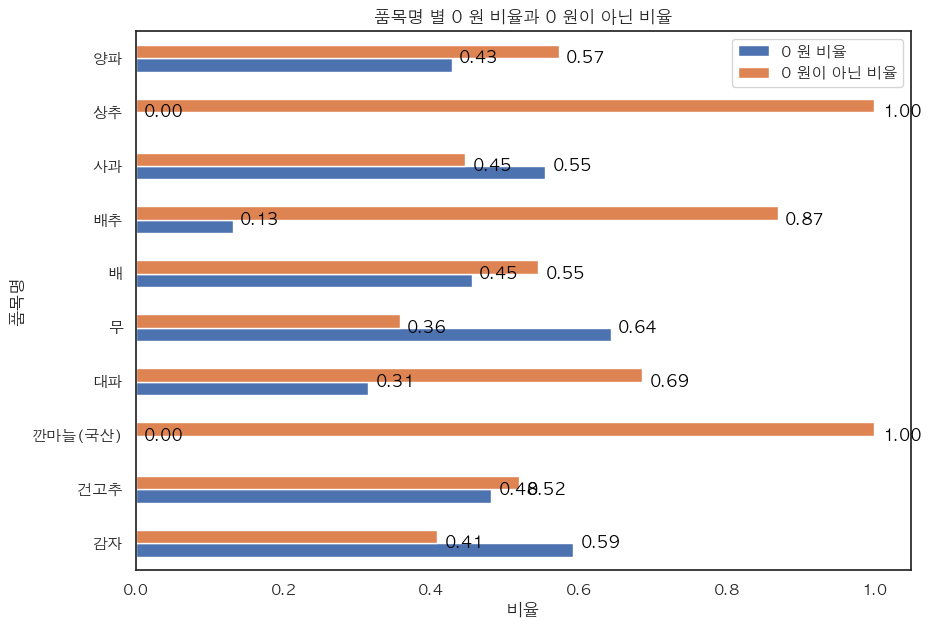

In [82]:
# 1. 품목명 별로 평균가격(원)이 0인 경우와 그렇지 않은 경우의 비율 계산
price_zero_ratio = train_df.groupby('품목명')['평균가격(원)'].apply(lambda x: (x == 0).sum() / x.shape[0])
price_non_zero_ratio = train_df.groupby('품목명')['평균가격(원)'].apply(lambda x: (x != 0).sum() / x.shape[0])

# 2. 두 데이터를 하나의 DataFrame으로 합침
ratio_df = pd.DataFrame({
    '0 원 비율': price_zero_ratio,
    '0 원이 아닌 비율': price_non_zero_ratio
})

# 3. Horizontal Bar Chart 그리기
ax = ratio_df.plot(kind='barh', stacked=True, figsize=(10, 7))

# 그래프 제목과 레이블 설정
plt.title('품목명 별 0 원 비율과 0 원이 아닌 비율')
plt.xlabel('비율')
plt.ylabel('품목명')

# 4. 각 막대에 값 표시
for container in ax.containers:
    ax.bar_label(container)

# 그래프 출력
plt.show()

---
### 2-2. 요약통계 지표 확인

---
### 2-3. 시각화 및 속성별 통계 지표 결정

- 품목명별 평균가격 분포

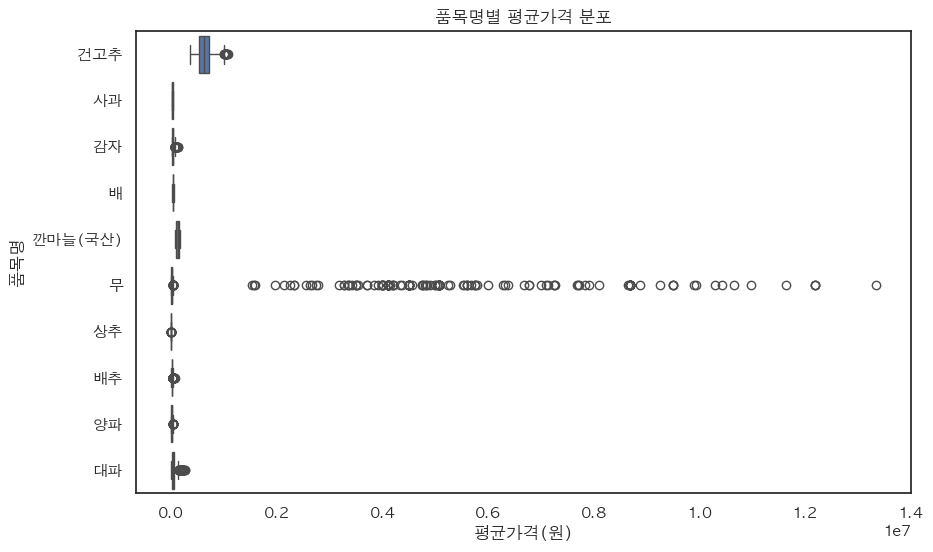

In [69]:
# 품목명별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='품목명', data=train_with_target_df)
plt.title('품목명별 평균가격 분포')
plt.show()

- 품종명별 평균가격 분포

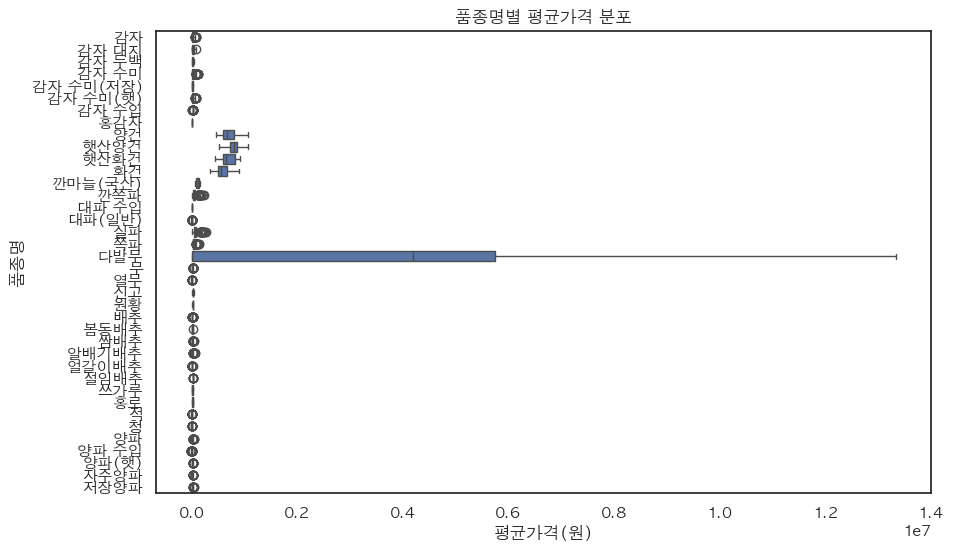

In [70]:
# 품종명별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='품종명', data=train_with_target_df.sort_values(['품목명','품종명']))
plt.title('품종명별 평균가격 분포')
plt.show()

- 거래단위별 평균가격 분포

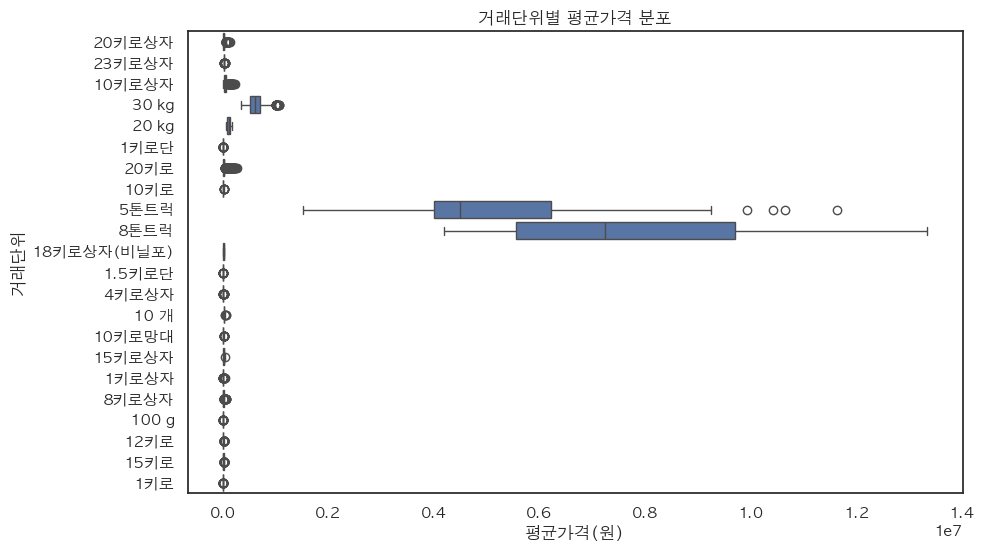

In [71]:
# 거래단위별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='거래단위', data=train_with_target_df.sort_values(['품목명','품종명','거래단위']))
plt.title('거래단위별 평균가격 분포')
plt.show()

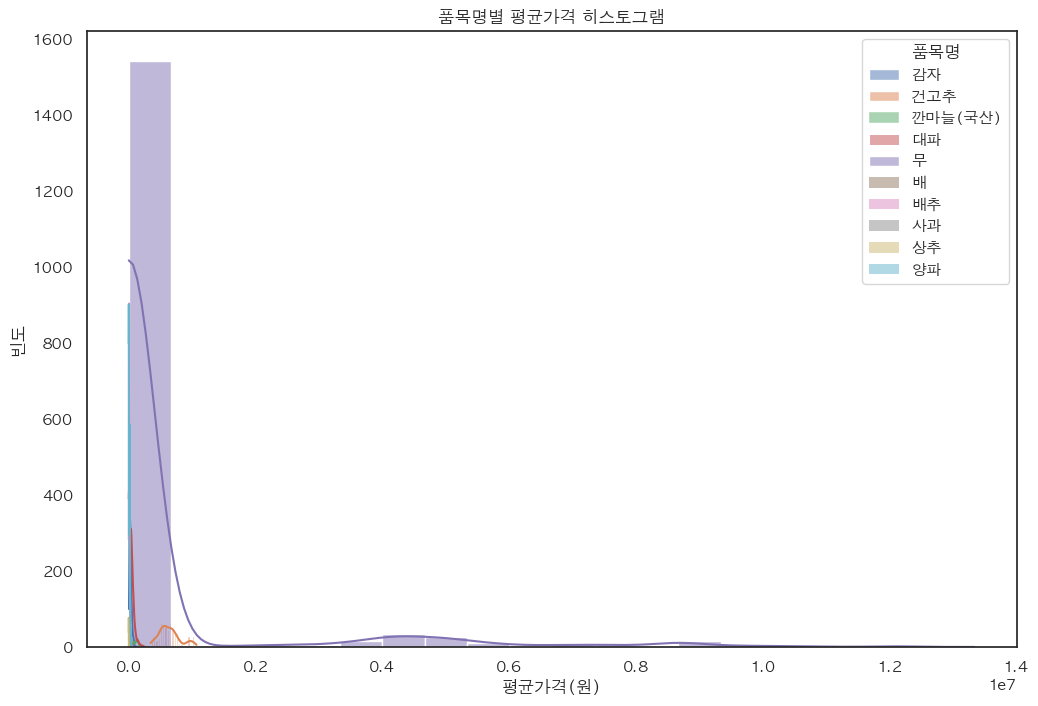

In [72]:
# 품목명별로 평균가격의 히스토그램 그리기
plt.figure(figsize=(12, 8))

for 품목명, group in train_with_target_df.groupby('품목명'):
    sns.histplot(group['평균가격(원)'], kde=True, label=품목명, bins=20)

plt.legend(title='품목명')
plt.title('품목명별 평균가격 히스토그램')
plt.xlabel('평균가격(원)')
plt.ylabel('빈도')
plt.show()

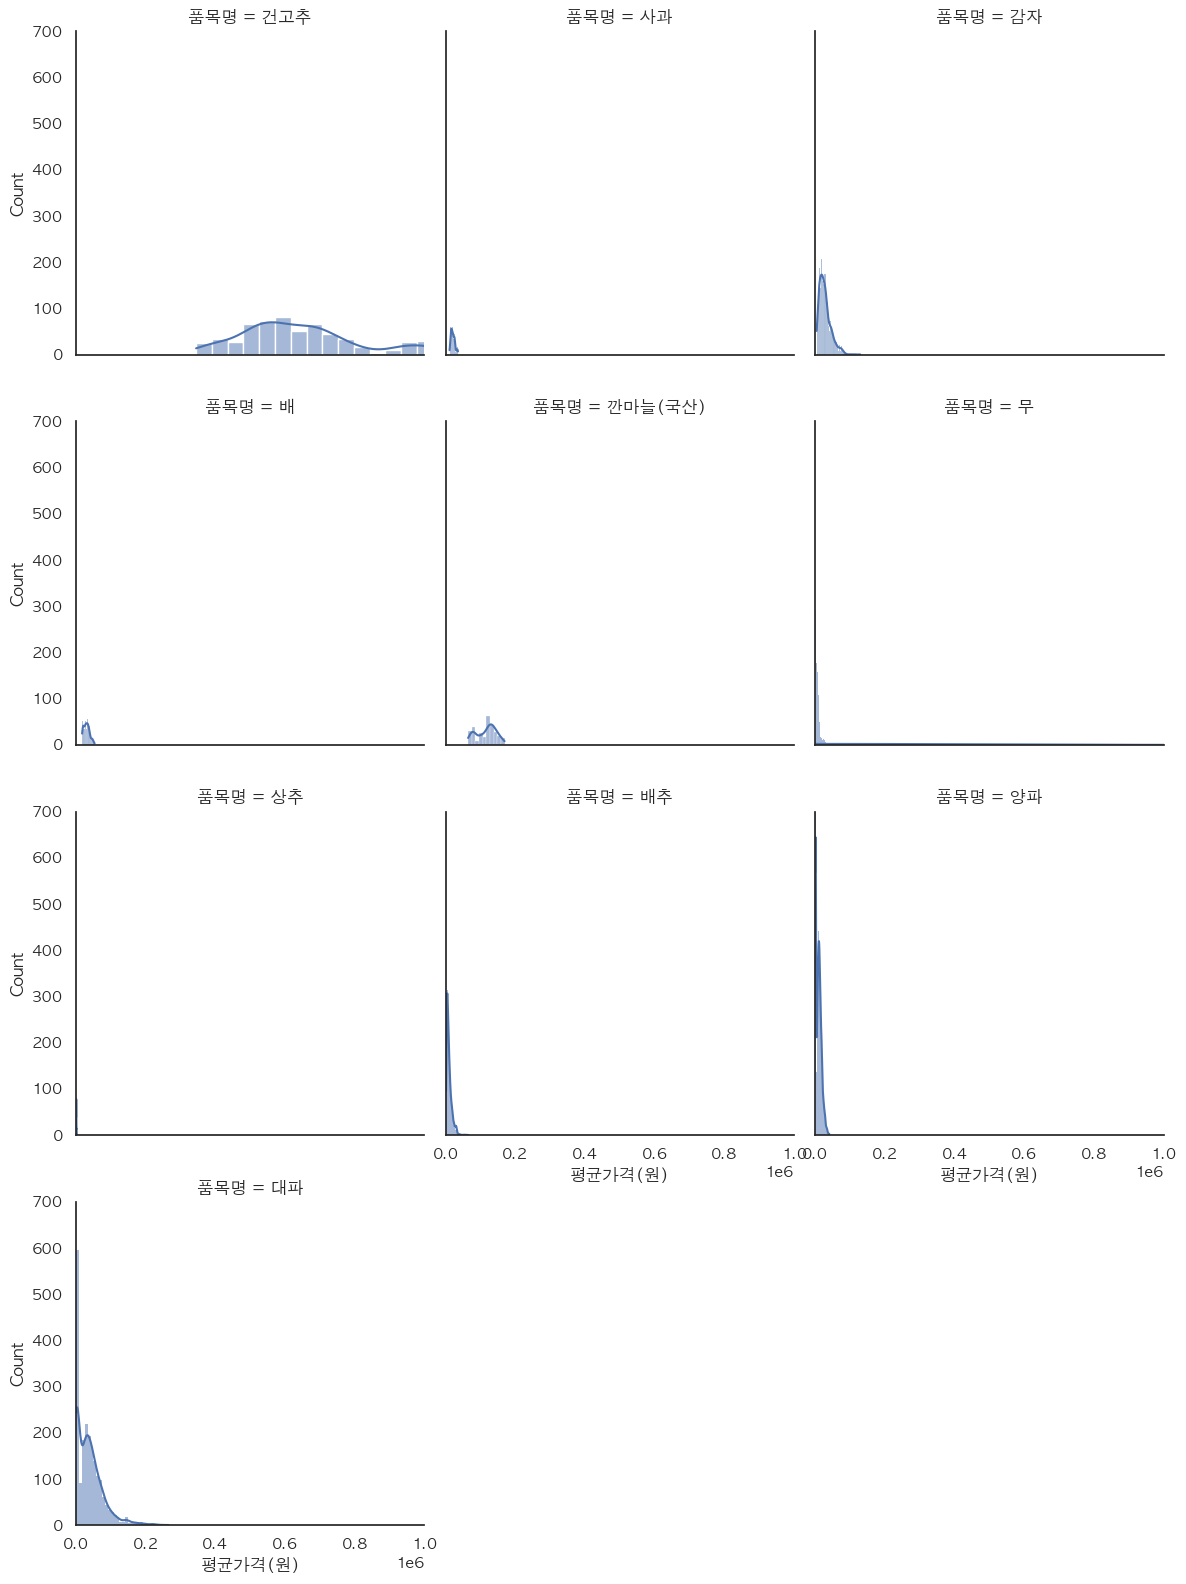

In [73]:
# 품목명별로 개별 히스토그램 그리기
g = sns.FacetGrid(train_with_target_df, col='품목명', col_wrap=3, height=4)
g.map(sns.histplot, '평균가격(원)', kde=True)
g.set(xlim=(0, 1e6), ylim=(0, 700))
plt.show()

- '건고추' 품목의 평균 거래 가격이 높다.
- '무' 품목 중 '다발무' 품종의 가격이 굉장히 높은 경우가 존재한다.
  - 대량 거래 건일 것 같다.
- 이런 튀는 값들을 처리하기 위해선, 거래 가격이 아니라 단위 가격을 계산해서 사용하는 것이 좋아 보임

---
- 단위가격(=중량별가격) 계산
  - 양을 나타낼 수 있는 공통된 기준별 가격을 계산해야 함.
  - 평균가격 = 거래단위 * 단위가격(=중량별가격)
  - 단위가격을 (1g 당 가격) 으로 설정
  - 거래단위를 g 단위로 변환해야 함
- '거래단위'를 '거래수량'과 '단위기준'으로 분리
  - '단위기준별중량' 을 정의
  - 평균가격 = 거래수량 * 단위기준 * 단위기준별중량 * 중량별가격(=단위가격)

In [74]:
# 거래 단위 분리
set(train_df['거래단위']) # 전체 거래단위

{'1.5키로단',
 '10 개',
 '100 g',
 '1000키로',
 '10키로',
 '10키로망대',
 '10키로묶음',
 '10키로상자',
 '12키로',
 '15키로',
 '15키로상자',
 '18키로상자(비닐포)',
 '1키로',
 '1키로단',
 '1키로상자',
 '20 kg',
 '20키로',
 '20키로상자',
 '23키로상자',
 '30 kg',
 '4키로상자',
 '5000키로',
 '5톤트럭',
 '8키로상자',
 '8톤트럭'}

In [75]:
def split_transaction_unit(data):
    import re
    match = re.match(r"([0-9.,]+)([^\d]*)", data)  # 숫자와 문자를 분리하는 정규 표현식
    if match:
        return (match.group(1), match.group(2).strip())

In [76]:
단위기준 = set()
for data in set(train_df['거래단위']):
    value_unit = split_transaction_unit(data)
    단위기준.add(value_unit[-1])

In [77]:
단위기준

{'g', 'kg', '개', '키로', '키로단', '키로망대', '키로묶음', '키로상자', '키로상자(비닐포)', '톤트럭'}

In [78]:
import re

# 숫자와 문자로 나누기
numbers = []
texts = []

for item in set(train_df['거래단위']):
    match = re.match(r"([0-9.,]+)([^\d]*)", item)  # 숫자와 문자를 분리하는 정규 표현식
    if match:
        numbers.append(match.group(1))  # 숫자 부분
        texts.append(match.group(2).strip())  # 문자 부분

# 결과 출력
print("숫자 부분:", numbers)
print("문자 부분:", texts)

숫자 부분: ['10', '18', '8', '10', '1', '15', '100', '10', '1.5', '1', '4', '20', '5', '12', '5000', '8', '20', '23', '15', '10', '20', '30', '1000', '1', '10']
문자 부분: ['키로망대', '키로상자(비닐포)', '톤트럭', '키로상자', '키로단', '키로상자', 'g', '키로묶음', '키로단', '키로상자', '키로상자', '키로상자', '톤트럭', '키로', '키로', '키로상자', 'kg', '키로상자', '키로', '키로', '키로', 'kg', '키로', '키로', '개']


In [79]:
def unit_price(x):
    x['']

In [80]:
train_df['단위가격'] = train_df.apply(unit_price)

KeyError: ''

---
## 3. 관계 분석
### 3-1. 속성 조합간 패턴 분석

---
### 3-2. 시각화 및 속성간 관계 분석

---
### 3-3. 상관계수 확인

---